# Visualize `2 Gene` simulation on `bifurcation` trajectory

Focus on `2-gene` `bifurcation` trajectory simulations, using the setting presented by [[FS-21]](https://www.nature.com/articles/s41467-021-25133-1), to visualize the problem setting and grid search.



# Preliminaries

In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import jax
import ott
from jax.config import config
config.update("jax_enable_x64", True)

from utils import fit_seeds, plot_trajectory, simulate_data, anndata_from_sim, plot_metrics, method_colors

import moscot as mc

In [2]:
mc.__version__

'0.2.1.dev7+g00b5161'

## Dependencies

We provide scripts which can be run on a SLURM based cluster scheduling system and output.

Running the scripts will: 
1. Produce simulated trajectories of types: "bifurcation", "convergent", "partial_convergent", and "mismatched_clusters"  using LineageOT by ([[FS-21]](https://www.nature.com/articles/s41467-021-25133-1)).
2. Compute the couplings using:
    1. LineageOT
    2. OT
    3. GW
    4. moslin
3. Evaluate coupling accuracy.

The output of the above evaluation is saved in 3 files used in this notebook:`"bifurcation_res_seeds.csv", "bifurcation_ancestor_errors_moslin.pkl" and  "bifurcation_descendant_errors_moslin.pkl"` saved under `DATA_DIR`.

To run the pipeline modify paths within `run.sh` to activate local environment and call:  `python3 run_sbatch.py`

## Set up paths

Define the paths for data and figures

In [3]:
%matplotlib inline
sys.path.insert(0, "../../../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "simulations/forrow_2gene"
DATA_DIR = DATA_DIR / "simulations/forrow_2gene"

plt.rcParams['figure.figsize'] = [1, 1]

## Set global parameters

In [4]:
flow_type = "bifurcation"
save = True

# Visualize sample trajectories

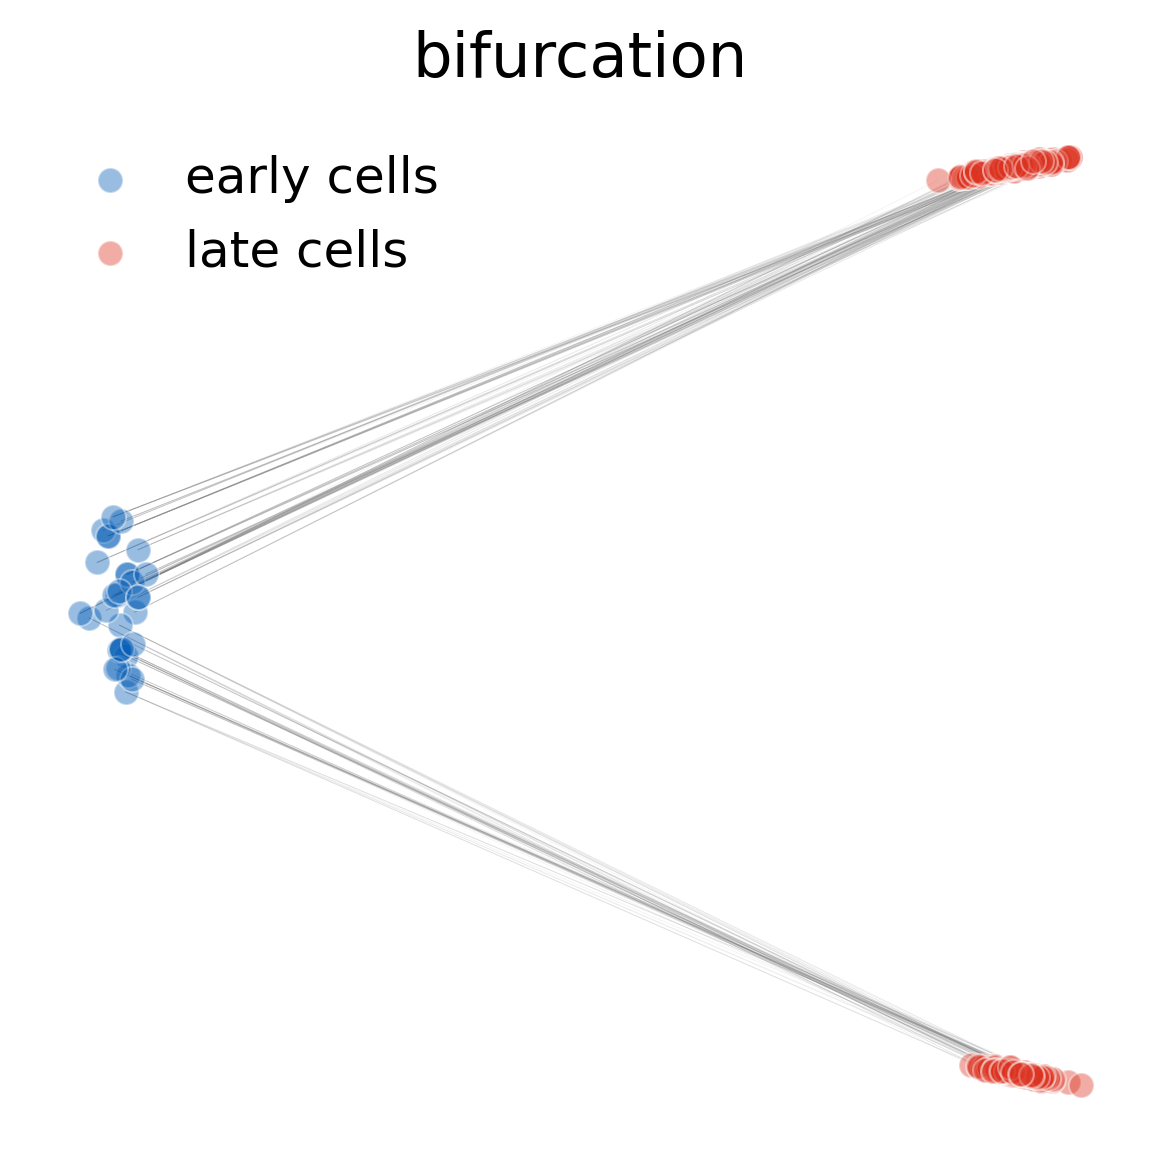

In [5]:
seed = 4698

sim = simulate_data(flow_type, seed=seed)
s, t = plot_trajectory(
    sim, 
    flow_type=flow_type, 
    savefig=save, 
    subsample=True, 
    alpha_scale=0.1, 
    linewidth=0.2,
    legend_off=False
)

In [6]:
adata = anndata_from_sim(sim, flow_type=flow_type)

### Plot sample cost matrices

In [7]:
cmat = adata.obsp["cost_matrices_true"]/ np.max(adata.obsp["cost_matrices_true"])
cmat[cmat == 0] = np.nan
np.fill_diagonal(cmat, 0)

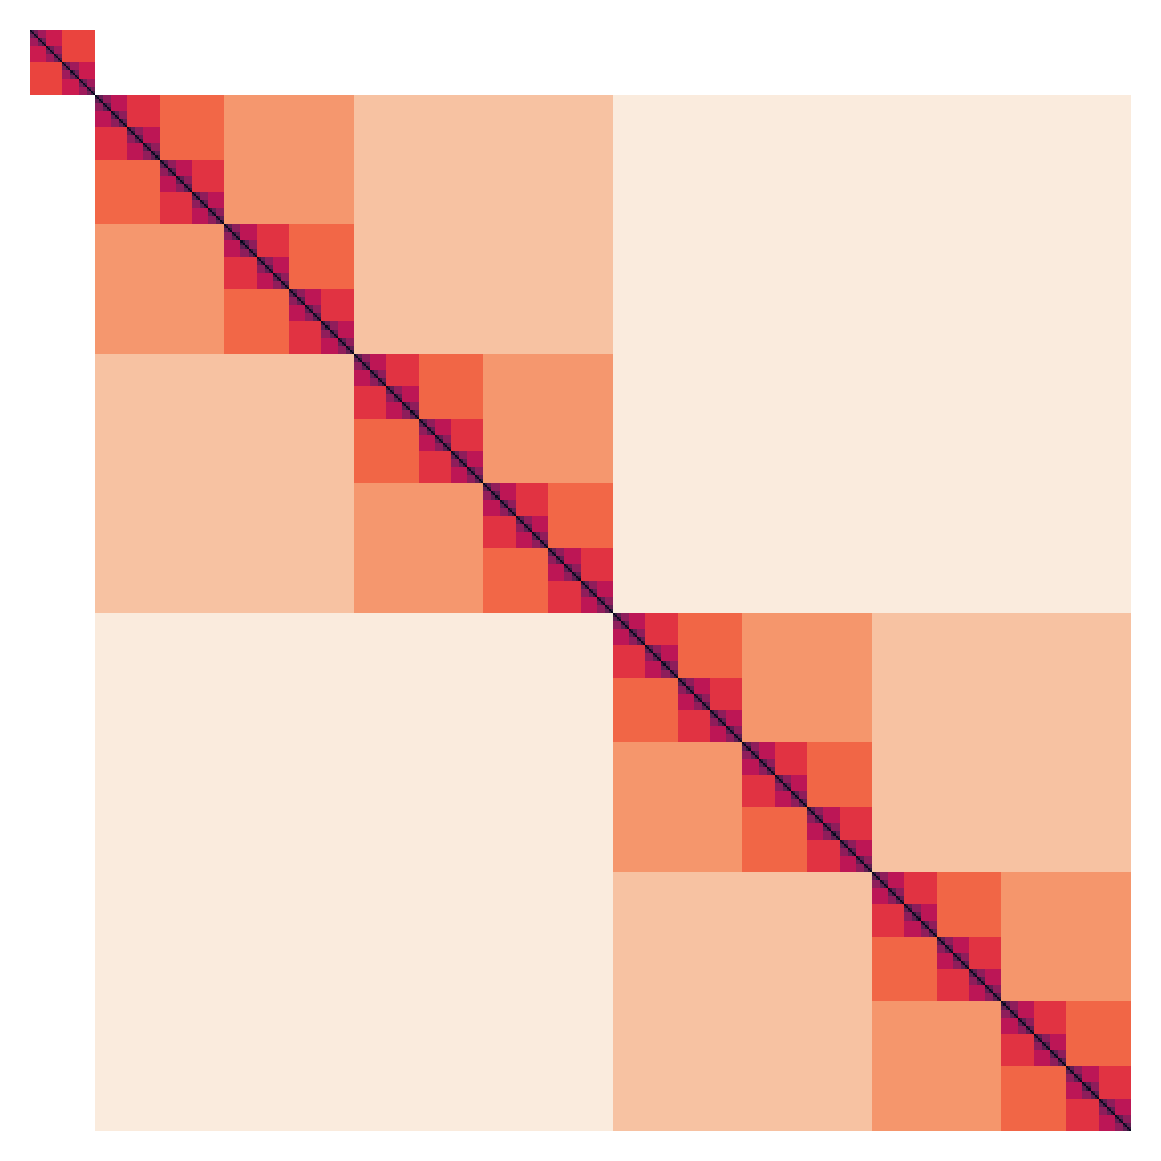

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(
    cmat, 
    xticklabels=[], 
    yticklabels=[],
    cbar=False,
    ax=axs,)

plt.tight_layout()
if save:
    plt.savefig(FIG_DIR / f"{flow_type}_cost_true.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

## Plot fit results

In [9]:
df = pd.read_csv(DATA_DIR / f"{flow_type}_res_seeds.csv")

with open(DATA_DIR / f"{flow_type}_ancestor_errors_moslin.pkl", "rb") as fin:
    ancestor_errors_moslin = pickle.load(fin)
with open(DATA_DIR / f"{flow_type}_descendant_errors_moslin.pkl", "rb") as fin:
    descendant_errors_moslin = pickle.load(fin)

In [10]:
mean_err = {}
for key in ["true", "fitted"]:
    mean_err[key] = {}
    for key_val in ancestor_errors_moslin[seed][key]:
        mean_err[key][key_val] = [ancestor_errors_moslin[seed][key][key_val][0], 
                                  [sum(x)/2 for x in zip(ancestor_errors_moslin[seed][key][key_val][1], descendant_errors_moslin[seed][key][key_val][1])]
                                 ]

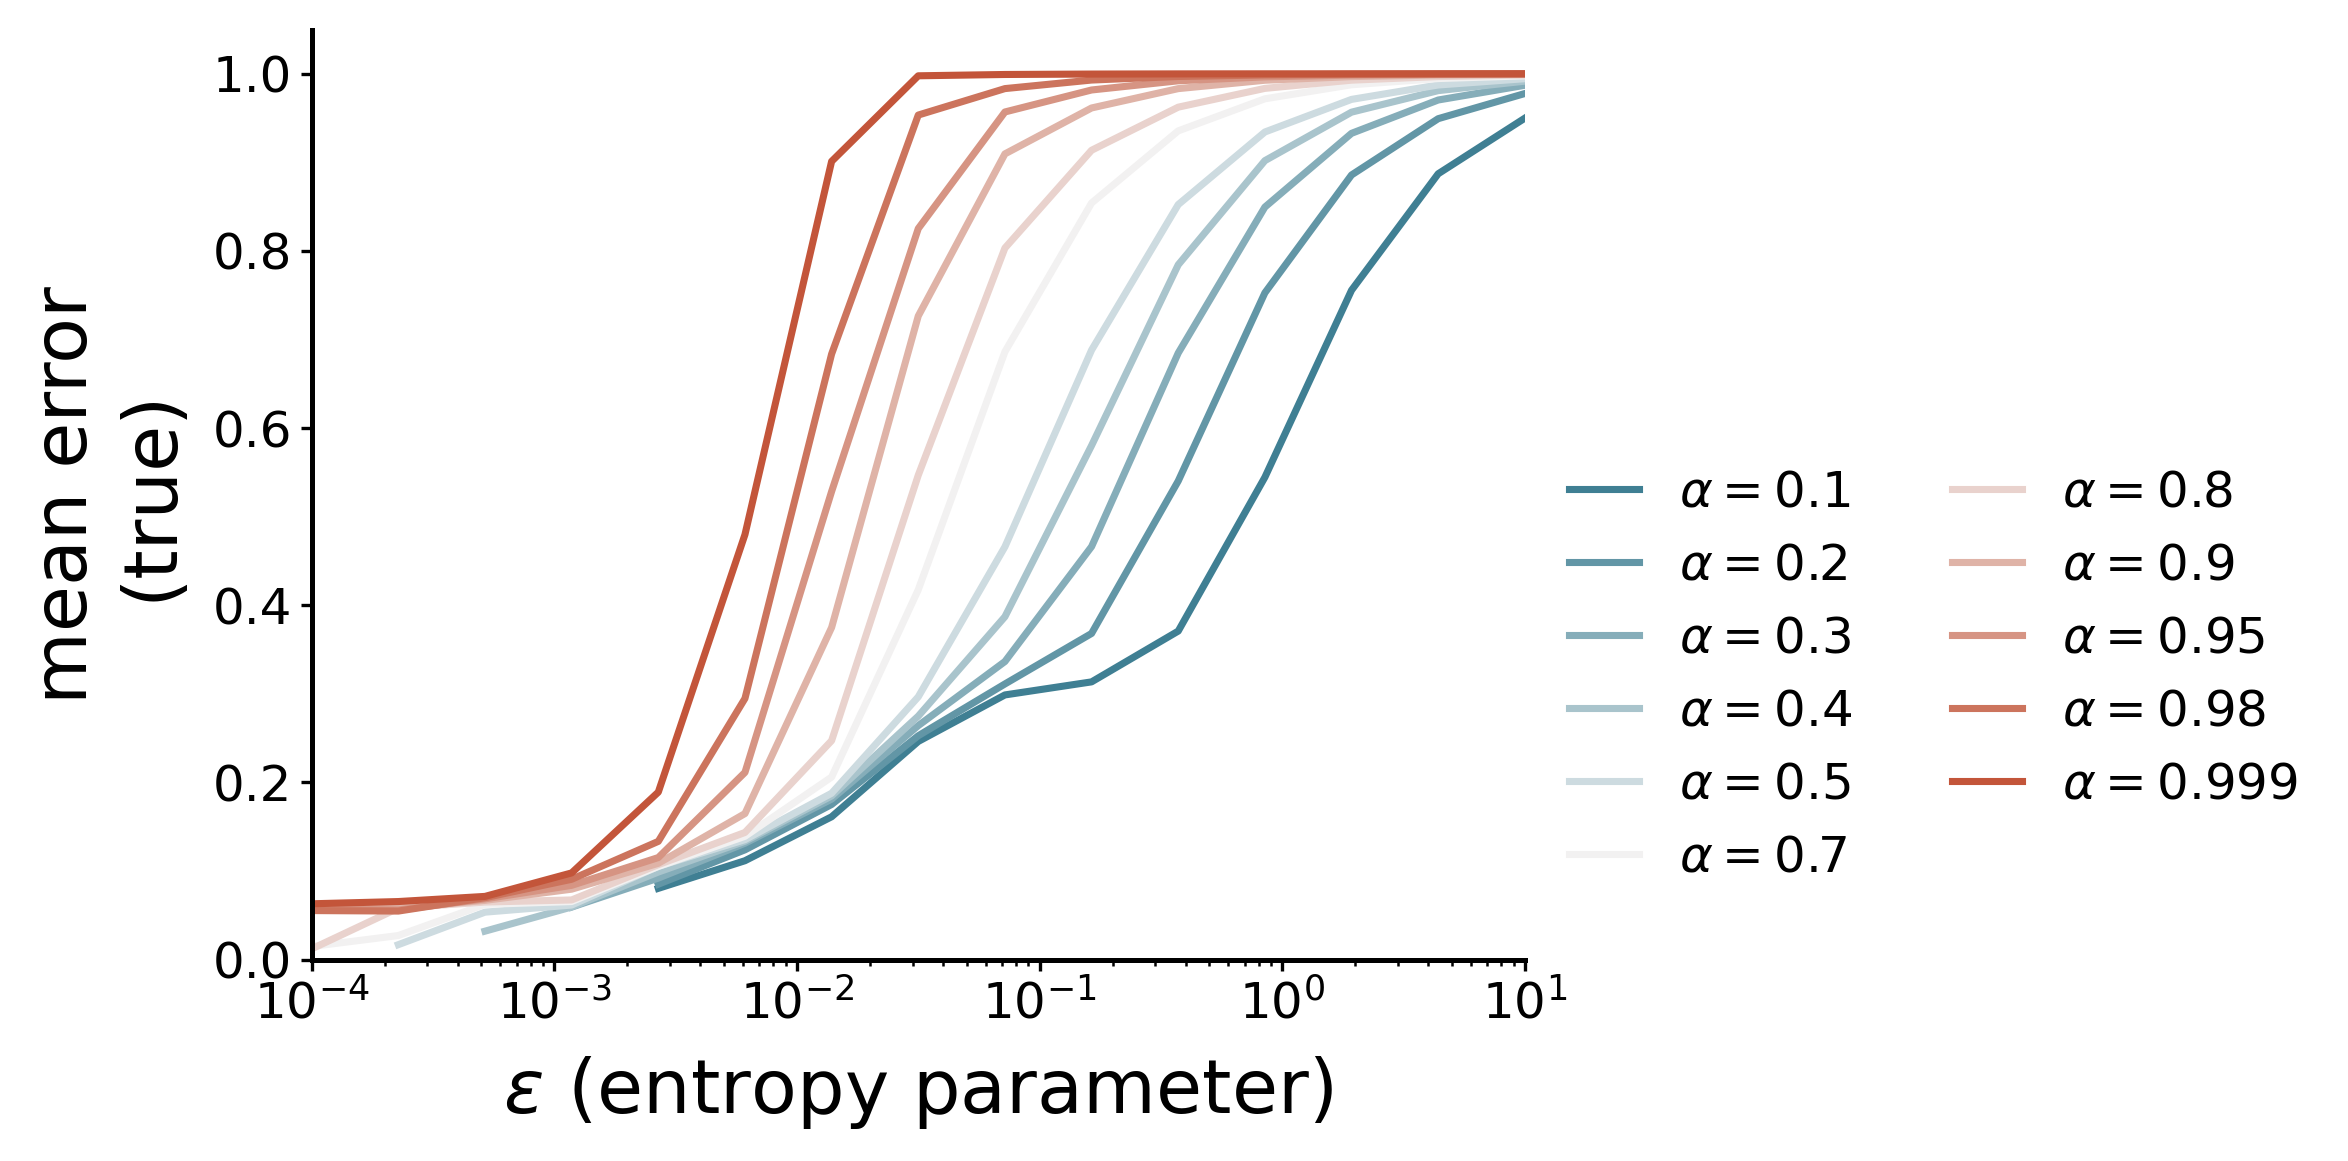

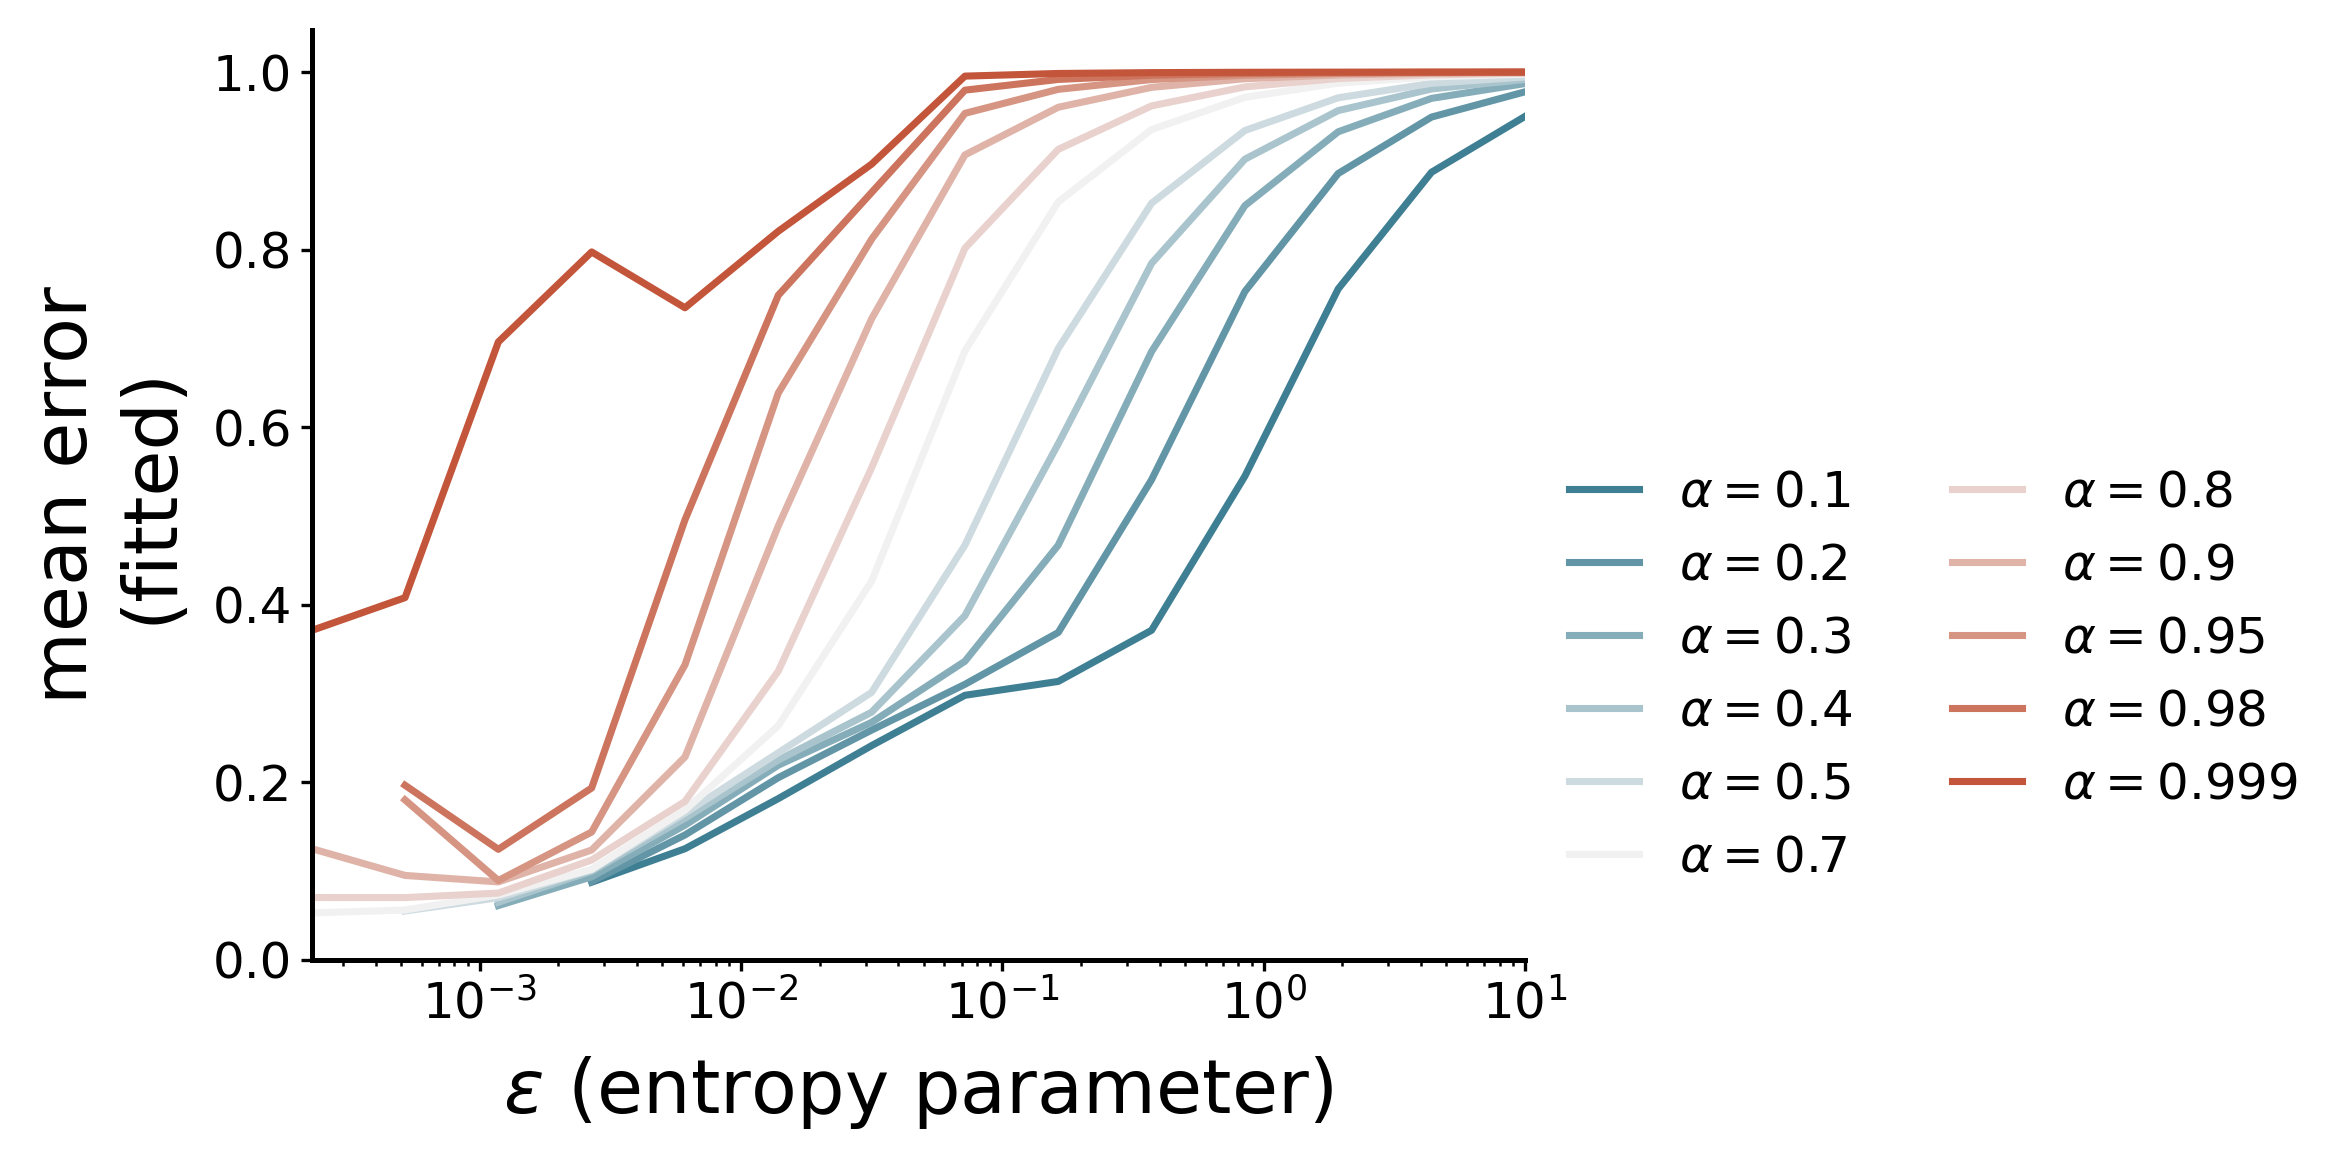

In [11]:
for key in ["true", "fitted"]:
    plot_metrics(
        mean_err[key],
        cost_func_name = f"mean error\n({key})",
        label_font_size=18, 
        tick_font_size=12,
    )

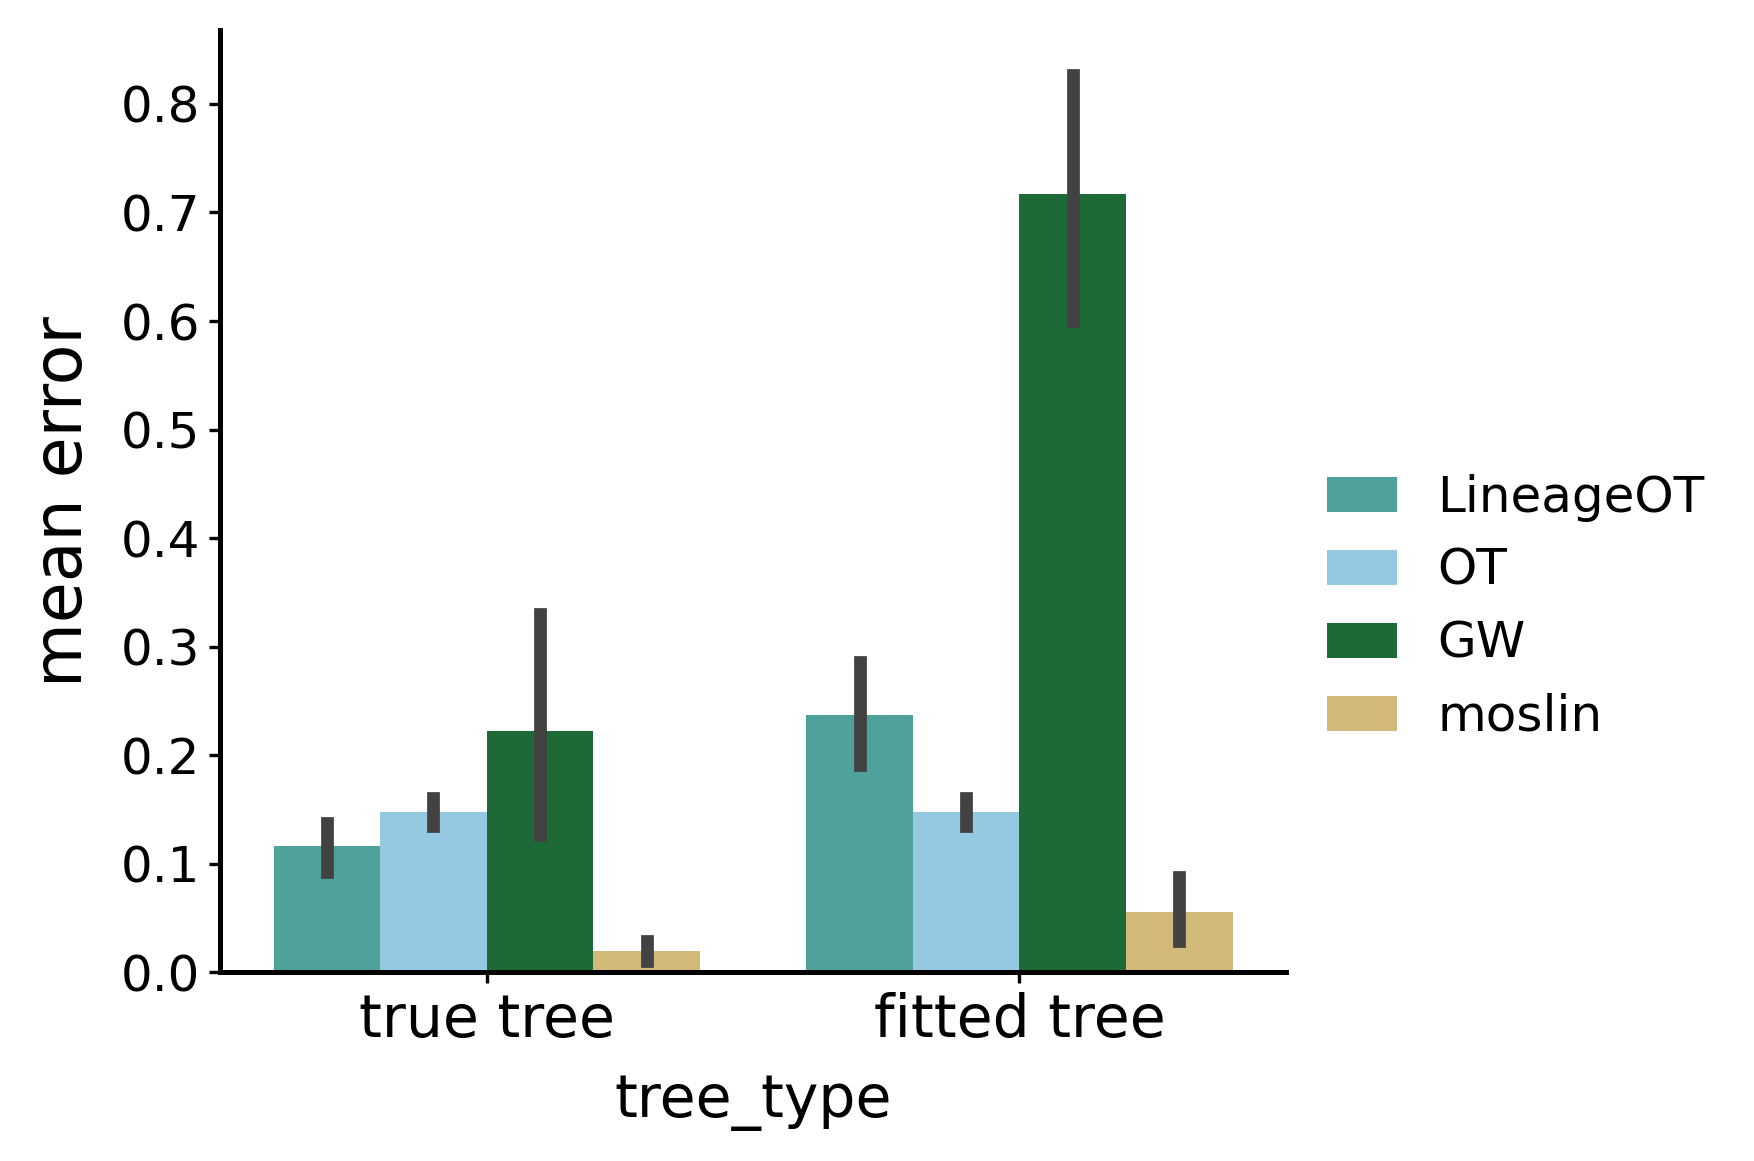

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(data=df, x="tree_type", y="mean_error", hue="method", palette=method_colors, ax=axs)
axs.set_xticklabels(["true tree", "fitted tree"], fontsize=14)
axs.set_ylabel("mean error", fontsize=16)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

# References

[[FS-21] Forrow, A., & Schiebinger, G. LineageOT is a unified framework for lineage tracing and trajectory inference. Nature communications, 12(1), 4940.](https://www.nature.com/articles/s41467-021-25133-1)